# Hello distributed world

The goal of this tutorial is to setup a simulation and run it by using a minimal example.


In [1]:
from pydistsim import NetworkGenerator, Simulation
from pydistsim.demo_algorithms.santoro2007.yoyo import YoYo


# Create a network with 30 nodes and undirected edges
net_gen = NetworkGenerator(30, directed=False)
net = net_gen.generate_random_network()

# Create a simulation object
sim = Simulation(net)

# Assign a simple algorithm to the network, must be a tuple
sim.algorithms = (YoYo,)

# Create and run the simulation
sim.run()

That's it! For more elaborate description please continue reading.


In [2]:
# For more detailed output, set the log level to INFO
from pydistsim.logging import set_log_level, LogLevels, enable_logger

set_log_level(LogLevels.INFO)
enable_logger()

In the example given above, the goal was to simulate distributed algorithm `YoYo` on arbitrary network. Algorithm `YoYo` solves _Election_ problem, i.e. the goal of the algorithm is to find the node with the lowest ID in the network.


### Generating network

Networks are fundamental objects in the PyDistSim and they can be created by instantiating `Network` class or by using `NetworkGenerator` class. `NetworkGenerator` can receive different parameters such as number of nodes (exact, min, max), average number of neighbors per node etc.

In this example, for simplicity, we use a simpler generator so the only parameter that we want to have in control is number of nodes. which is set to 11.


In [3]:
net = NetworkGenerator.generate_star_network(11)

The result is an instance of the BidirectionalNetwork class:


In [4]:
net

which can be visualized with its `show()` method:


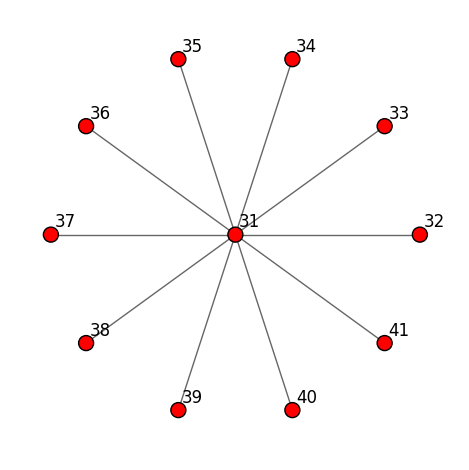

In [16]:
net.show()

Now, we create the simulation object and set the network to the one we just created:


In [6]:
sim = Simulation(net)

2024-09-02 21:37:09.829 | INFO     | pydistsim.simulation:__init__:58 - Simulation 0x7f5dfb567710 created successfully.


### Algorithm and Simulation

To demonstrate the simulation, we will use a simple `Echo` algorithm. The algorithm is a simple flooding algorithm that sends a message to all neighbors and waits for the response from all of them. Once every neighbor responds, the algorithms terminates.

Implementation of `Echo` algorithm is given below:


In [7]:
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.topological import Connectivity, UniqueInitiator


class Echo(NodeAlgorithm):
    default_params = {
        "echo_message": "Hello world!",
    }

    class Status(StatusValues):
        INITIATOR = "INITIATOR"
        AWAITING_ECHO = "AWAITING_ECHO"
        AWAITING_ECHO_RESPONSE = "AWAITING_ECHO_RESPONSE"
        DONE = "DONE"

    S_init = (Status.INITIATOR, Status.AWAITING_ECHO)
    S_term = (Status.DONE,)

    # Here we define under which restrictions the algorithm is designed to work
    algorithm_restrictions = (
        BidirectionalLinks,  # The algorithm requires bidirectional links, so that the response can be sent back
        TotalReliability,  # The algorithm requires that all messages are delivered without loss
        Connectivity,  # The algorithm requires that the network is connected
        UniqueInitiator,  # The algorithm requires that only one node is the initiator
    )

    def initializer(self):
        # Set all nodes to AWAITING_ECHO
        for node in self.network.nodes():
            node.status = self.Status.AWAITING_ECHO

        # Choose the initiator
        ini_node = self.network.nodes_sorted()[0]

        # Send the initial message to the initiator
        ini_node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=ini_node))

        # Set the initiator status to INITIATOR and store the initial information
        ini_node.status = self.Status.INITIATOR
        ini_node.memory["message"] = self.echo_message

    @Status.INITIATOR
    def spontaneously(self, node: NodeAccess, message: Message):
        self.send(
            node,
            data=node.memory["message"],
            destination=list(node.neighbors()),  # send to all neighbors
            header="Echo",
        )
        node.memory["responseCount"] = 0
        node.status = self.Status.AWAITING_ECHO_RESPONSE

    @Status.AWAITING_ECHO_RESPONSE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "Echo response":
            # Count the number of responses received, only if the response is the same as the original message
            node.memory["responseCount"] += 1 if message.data == node.memory["message"] else 0

            # If all responses have been received, set the node status to DONE
            if node.memory["responseCount"] == len(list(node.neighbors())):
                node.status = self.Status.DONE

    @Status.AWAITING_ECHO
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "Echo":
            node.memory["message"] = message.data

            self.send(
                node,
                data=message.data,
                destination=message.source,
                header="Echo response",
            )
        node.status = self.Status.DONE

    @Status.DONE
    def default(self, *args, **kwargs):
        "Do nothing, for all inputs."
        pass

#### Assigning algorithm to the simulation

Two things should be noted:

- there can be multiple algorithms that are being assigned to the simulation so specific algorithms are elements of `tuple`. Since in this example there is only one algorithm we must append `,` so that Python knows it's a one element `tuple` i.e. `(1)` is `int`, but `(1,)` is `tuple`.
- every algorithm element is `tuple` itself, consisting of two elements. Former is an algorithm class, in this example `Echo`. Later is a `dict` of keyword parameters, i.e. `Echo` must be given 'echo_message' as an optional parameter: the message to be sent.


In [8]:
sim = Simulation(net)
MESSAGE = "Hello distributed world"
sim.algorithms = ((Echo, {"echo_message": MESSAGE}),)

2024-09-02 21:37:09.862 | INFO     | pydistsim.simulation:__init__:58 - Simulation 0x7f5dfb54e090 created successfully.


### Running


Finally, run simulation:


In [9]:
sim.run()

2024-09-02 21:37:09.881 | INFO     | pydistsim.simulation:_run_algorithm:147 - [Echo] Algorithm finished


After the algorithm(s) execution is done we can check if the resullt is as expected, that is every node should have information in their memory:


In [10]:
for node in net.nodes():
    assert node.memory["message"] == MESSAGE, "Oh..."
    assert node.status == Echo.Status.DONE, "Oh..."

print("Everything is OK!")

Everything is OK!


During simulation execution, network and its nodes are changing their status, memory content etc. To memorize the currently running algorithm and current step of the simulation, network has a special attribute `algorithmsState`:


In [11]:
sim.algorithmState

{'index': 0, 'step': 17, 'finished': True}

If simulation is going to be run again, it must be reset:


In [12]:
sim.reset()

whereby:

- `algorithmState` is returned to the initial value:


In [13]:
sim.algorithmState

{'index': 0, 'step': 1, 'finished': False}

- memory content of all node's is deleted (as long as some other attributes)


In [14]:
for node in net.nodes():
    assert len(node.memory) == 0
print("All memories are empty!")

All memories are empty!


In [15]:
sim.run()

2024-09-02 21:37:09.934 | INFO     | pydistsim.simulation:_run_algorithm:147 - [Echo] Algorithm finished
